The purpose of this calculation is to reproduce the results from [Asuncion et al., Philippine Journal of Science, 2019](https://github.com/pgniewko/conotoxins/tree/master/papers/ML/ASA.PJS.2019.pdf). The data used in this work is downloaded from the [ConoServer](http://www.conoserver.org/?page=download) (access data: 11/18/19). Instead of using [protr](https://cran.r-project.org/web/packages/protr/vignettes/protr.html) package for peptides featurizaion, I use a Python implementation [pydpi](https://pypi.org/project/pydpi/#files). `pydpi` was originally implemented in Python 2, so to make it work with my code I have [reimplemented](https://github.com/pgniewko/conotoxins/tree/master/external/py3dpi) it in Python 3. Other tools also exist, e.g. [iFeature](https://github.com/Superzchen/iFeature/) by [Chen et al., Bioinformatics 2018](https://github.com/pgniewko/conotoxins/tree/master/papers/ML/iFeature.2018.pdf).

In [104]:
import sys
import xml.etree.ElementTree as ET


from toxin import Toxin
from experiment import Experiment


import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

First we read and parse XML file. Then we create a toxin object for all available data.

In [96]:
db_file = "../data/conoserver/conoserver_protein.xml"
tree = ET.parse(db_file)
root = tree.getroot()

toxins = []
for entry in root.iter('entry'):
    pid = entry.find('id').text if entry.find('id') is not None else None
    seq = entry.find('sequence').text if entry.find('sequence') is not None else "None"
    name = entry.find('name').text if entry.find('name') is not None else "None"
    toxin_class =  entry.find('class').text if entry.find('class') is not None else "None"
    organism = entry.find('organismLatin').text if entry.find('organismLatin') is not None else "None"
    geneSuperfamily = entry.find('geneSuperfamily').text if entry.find('geneSuperfamily') is not None else "None"
    cysteineFramewrok = entry.find('cysteineFramewrok').text if entry.find('cysteineFramewrok') is not None else "None"
    pharmacologicalFamily = entry.find('pharmacologicalFamily').text if entry.find('pharmacologicalFamily') is not None else "None"
    isoelecticPoint = entry.find('isoelecticPoint').text if entry.find('isoelecticPoint') is not None else "None"
    
    toxin = Toxin(pid,
                  seq,
                  name,
                  toxin_class,
                  organism,
                  geneSuperfamily,
                  cysteineFramewrok,
                  pharmacologicalFamily, 
                  isoelecticPoint)
    
    mods = entry.find('sequenceModifications')
    if mods is not None:
        for mod in mods.iter('modification'):
            toxin.add_modification( mod.attrib )
    
    toxin._clean_seq()
    toxins.append(toxin)

I tried to ways of building the dataset. The first one was an automated parsing of the XML file, given the specs provied in the paper. The second approach was to take the protein ids, sequences and molecular targets from the [paper](). I noticed that the data in the paper differes (moslty for $\alpha$-toxins) from the paper. It seems that the data used in the paper was manually curated. Some toxins that don't have specified target, were included wheres some peptides that have well defined target were exluded from the dataset. Moreover, 4 peptides that were inlcuded in the original study, is missing in the data downlaoded from ConoServer. It due to the fact, that for these 4 cases, a precursor is ginve not an actuall mature peptide. To be able to work with these cases, the following changes weremade to their sequneces:

|Protein ID| Position  | Mature amino-acid | Original amino-acid|        
|------|----|---|----|   
|P06822| 2  | X | W  |    
|P06822| 6  | X | P  |    
|P06822| 24 | X | C  |
|P07401| 2  | X | E  |    
|P07401| 3  | X | E  |    
|P07401| 7  | X | E  |
|P07401| 10 | X | "" |
|P07646| 4  | X | P  |
|P07646| 10 | X | P  |
|P07647| 4  | X | P  |  
|P07647| 10 | X | P  |

For the other amino-acids, the sequence was changed to the original sequence using information contained in `sequenceModifications` field.

In [97]:
experiment = Experiment(toxins, min_val=8)
if False:
    experiment.prepare_experiment()
else:
    experiment.experiment_from_file('../data/ASA.PJS.2019.txt')

data, labels, labels_map = experiment.get_data()   

Can't find protein with id P06822. Createing a new object with seq: GWCGDPGATCGKLRLYCCSGFCDCYTKTCKDKSSA and class: sodium
Can't find protein with id P07401. Createing a new object with seq: GEEEYSEAI and class: NMDARs
Can't find protein with id P07646. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYY and class: calcium
Can't find protein with id P07647. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYYN and class: calcium
GCPWDPWC
Skipping P01270 protein, with a sequence: GCPWDPWC
GCPWDPWC
Skipping P01272 protein, with a sequence: GCPWDPWC
GDCPKPWC
Skipping P01309 protein, with a sequence: GDCPKPWC


Now, the data is featurized we want to turn the features into Z-scores. However, we have a sample of only 153 sequences, and some of the peptides are failry small and many features are absent in all the studied cases. Thus to avoid any numerical issues and exceptions, I removed all the empty columns. Once the empty columns were removed I transformed it into Z-scores, and then transormed into PC spaces and retained only 100 most important one.

In [98]:
data_cleaded = []
for i in range(data.shape[1]):
    std= np.std(data[:,i])
    if std != 0:
        data_cleaded.append(data[:,i])
data_cleaded = np.array(data_cleaded)
data_cleaded = data_cleaded.T

zscores = stats.zscore(data_cleaded, axis=0, ddof=1)
pca = PCA(n_components=100)
zscores_pca = pca.fit_transform(zscores)

First I plot the amount of data variation explained by a certain number of Principal Components.

Text(0, 0.5, 'X 2')

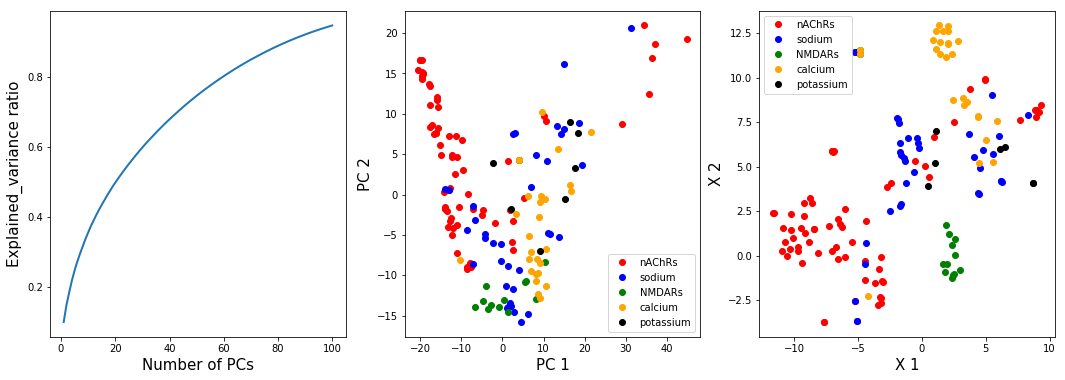

<Figure size 504x504 with 0 Axes>

In [100]:
fig, axis = plt.subplots(1, 3, figsize=(18,6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]


y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

fig = plt.figure(figsize=(7, 7))
ax1.plot(x, y, lw=2)
ax1.set_xlabel('Number of PCs', fontsize=15)
ax1.set_ylabel('Explained_variance ratio', fontsize=15)


# Each class correspond to the molecular target
color_map = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'black'}

for label, color in color_map.items():
    x = [zscores_pca[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [zscores_pca[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x, y, 'o', c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("PC 1", fontsize=15)
ax2.set_ylabel("PC 2", fontsize=15)

# Embed first 10 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca[:,0:10])

for label, color in color_map.items():
    x = [X_embedded[i,0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels)) if labels[i] == label]
    ax3.plot(x,y,'o', c=color, label=labels_map[label])
ax3.legend()
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)

In [101]:
X = zscores_pca[:,0:50]
y = labels
y_true = []
y_pred = []
kf = KFold(n_splits=50, random_state=42, shuffle=True )
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg')).fit(X_train, y_train)
    y_pred += list(clf.predict(X_test))
    y_true += list(y_test)

In [107]:
print("Accuracy= ", accuracy_score(y_true, y_pred))
print("F1-score= ", f1_score(y_true, y_pred, average='weighted'))
print("Precision= ", precision_score(y_true, y_pred,average='weighted'))
print("Recall= ", recall_score(y_true, y_pred, average='weighted'))
print("Cohen kappa=", cohen_kappa_score(y_true, y_pred))
print("Multiclass")
print(precision_recall_fscore_support(y_true, y_pred))
print("Confusion Matrix")
confusion_matrix(y_true, y_pred)

Accuracy=  0.869281045751634
F1-score=  0.8694395260891424
Precision=  0.8732959850606908
Recall=  0.869281045751634
Cohen kappa= 0.811367279003822
Multiclass
(array([0.94285714, 0.75      , 1.        , 0.77777778, 1.        ]), array([0.97058824, 0.78947368, 0.84615385, 0.77777778, 0.71428571]), array([0.95652174, 0.76923077, 0.91666667, 0.77777778, 0.83333333]), array([68, 38, 13, 27,  7]))
Confusion Matrix


array([[66,  2,  0,  0,  0],
       [ 3, 30,  0,  5,  0],
       [ 0,  1, 11,  1,  0],
       [ 0,  6,  0, 21,  0],
       [ 1,  1,  0,  0,  5]])